# Чтение, обработка и сравнение данных из CSV файлов

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [2]:
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17
name_field_index = 18

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

trace_dir1 = "Tensorflow-HP"
trace_dir2 = "HPCG"
#filename1 = "nvidia-smi-tfhp.csv"
filename1 = "nvprof-trace-tfhp.csv"
#filename2 = "nvidia-smi-hpcg.csv"
filename2 = "nvprof-trace-hpcg.csv"

maxrows = 10000

file1 = os.path.join(trace_dir1,filename1)
file2 = os.path.join(trace_dir2,filename2)

In [4]:
print "Reading",file1,file2

columns = [time_field_index, duration_field_index,
           SSMem_field_index, DSMem_field_index,
           size_field_index, throughput_field_index,
           src_field_index, dst_field_index,
           context_index, stream_index,
           name_field_index]


Reading Tensorflow-HP/nvprof-trace-tfhp.csv HPCG/nvprof-trace-hpcg.csv


In [22]:
print file1
df_tf = pd.read_csv(file1, header = 0, usecols = columns, 
                 skiprows=[0,1,2,4], nrows = maxrows)

Tensorflow-HP/nvprof-trace-tfhp.csv


In [23]:
print file2
df_hpcg = pd.read_csv(file2, header = 0, usecols = columns, 
                 skiprows=[0,1,2,4], nrows = maxrows)

HPCG/nvprof-trace-hpcg.csv


In [24]:
df_tf.iloc[1000:1005]

,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
1000,2.237229,0.003200,0.042969,0.0,NaN,NaN,NaN,NaN,1,14,void tensorflow::functor::BlockReduceKernel<cu...
1001,2.237236,0.004384,0.000000,0.0,NaN,NaN,NaN,NaN,1,14,void Eigen::internal::EigenMetaKernel<Eigen::T...
1002,2.237244,0.003904,0.042969,0.0,NaN,NaN,NaN,NaN,1,14,void tensorflow::functor::BlockReduceKernel<cu...
1003,2.237251,0.003904,0.000000,0.0,NaN,NaN,NaN,NaN,1,14,void tensorflow::functor::CleanupSegments<floa...
1004,2.237259,0.003232,0.000000,0.0,NaN,NaN,NaN,NaN,1,14,void Eigen::internal::EigenMetaKernel<Eigen::T...


In [25]:
df_hpcg.iloc[1000:1005]

,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
1000,42.373753,0.014848,3.0,0.0,NaN,NaN,NaN,NaN,1,7,"trans_kernel(double*, int*, double*, int*) [6255]"
1001,42.373770,0.014944,3.0,0.0,NaN,NaN,NaN,NaN,1,7,"trans_kernel(double*, int*, double*, int*) [6261]"
1002,42.373789,0.014688,3.0,0.0,NaN,NaN,NaN,NaN,1,7,"trans_kernel(double*, int*, double*, int*) [6267]"
1003,42.373806,0.015104,3.0,0.0,NaN,NaN,NaN,NaN,1,7,"trans_kernel(double*, int*, double*, int*) [6273]"
1004,42.373824,0.014752,3.0,0.0,NaN,NaN,NaN,NaN,1,7,"trans_kernel(double*, int*, double*, int*) [6279]"


## Select columns with memory operations

In [26]:
df_tf_cuda = df_tf.loc[df_tf['Name'].str.contains('\[CUDA')]
df_hpcg_cuda = df_hpcg.loc[df_hpcg['Name'].str.contains('\[CUDA')]

In [27]:
df_tf_cuda['FullName'] = df_tf_cuda['Name'] + " " + df_tf_cuda['SrcMemType']+df_tf_cuda['DstMemType'].fillna("")
df_hpcg_cuda['FullName'] = df_hpcg_cuda['Name'] + " " + df_hpcg_cuda['SrcMemType']+df_hpcg_cuda['DstMemType'].fillna("")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [28]:
df_hpcg_cuda.iloc[:5]

,Start,Duration,Static SMem,Dynamic SMem,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name,FullName
0,12.257619,0.002080,NaN,NaN,0.000107,0.050148,Pageable,Device,1,7,[CUDA memcpy HtoD],[CUDA memcpy HtoD] PageableDevice
1,17.538188,0.003712,NaN,NaN,0.000004,0.001004,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device
3,17.557663,0.003168,NaN,NaN,0.000004,0.001176,Device,Pageable,1,7,[CUDA memcpy DtoH],[CUDA memcpy DtoH] DevicePageable
4,17.564471,0.004256,NaN,NaN,0.000103,0.023633,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device
5,17.564478,0.002432,NaN,NaN,0.000103,0.041358,Device,NaN,1,7,[CUDA memset],[CUDA memset] Device


In [29]:
def mergeColumnNames(df_org):
    df = df_org.pivot(index = 'Start', columns = 'FullName', 
                         values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df
#df_tf_throughput.iloc[:10]

In [56]:
df_tf_throughput = mergeColumnNames(df_tf_cuda)
df_hpcg_throughput = mergeColumnNames(df_hpcg_cuda)

In [57]:
df_hpcg_throughput.iloc[:5]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePageable,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,,,
12.257619,0.0,0.000000,0.0,0.050148,0.0,0.000000
17.538188,0.0,0.000000,0.0,0.000000,0.0,0.001004
17.557663,0.0,0.001176,0.0,0.000000,0.0,0.000000
17.564471,0.0,0.000000,0.0,0.000000,0.0,0.023633
17.564478,0.0,0.000000,0.0,0.000000,0.0,0.041358


In [58]:
df_tf_throughput.iloc[:5]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,,
0.817201,0.0,0.0,0.0,0.000000,0.231928
1.201508,0.0,0.0,0.0,0.946105,0.000000
1.201676,0.0,0.0,0.0,0.002985,0.000000
1.201812,0.0,0.0,0.0,0.002985,0.000000
1.201944,0.0,0.0,0.0,0.186265,0.000000


In [59]:
def appendMaxValues2ColumnNames(df,series):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        col_names.append(series+df.columns[i]+" " +str(df.iloc[:,i].max()))
    df.columns = col_names
    return df

In [60]:
df_tf_throughput = appendMaxValues2ColumnNames(df_tf_throughput,"TF")
df_hpcg_throughput = appendMaxValues2ColumnNames(df_hpcg_throughput,"HPCG")

In [61]:
df_hpcg_throughput.iloc[:5]

,HPCG[CUDA memcpy DtoD] DeviceDevice 91.920416,HPCG[CUDA memcpy DtoH] DevicePageable 8.030909,HPCG[CUDA memcpy DtoH] DevicePinned 12.210065,HPCG[CUDA memcpy HtoD] PageableDevice 6.859424,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319035,HPCG[CUDA memset] Device 18084.490741
Start,,,,,,
12.257619,0.0,0.000000,0.0,0.050148,0.0,0.000000
17.538188,0.0,0.000000,0.0,0.000000,0.0,0.001004
17.557663,0.0,0.001176,0.0,0.000000,0.0,0.000000
17.564471,0.0,0.000000,0.0,0.000000,0.0,0.023633
17.564478,0.0,0.000000,0.0,0.000000,0.0,0.041358


In [62]:
plt.rcParams['figure.figsize'] = 12,8

In [63]:
df_full = pd.concat([df_tf_throughput,df_hpcg_throughput], axis = 1)

In [64]:
df_full.iloc[:5]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609326,TF[CUDA memcpy DtoH] DevicePinned 0.005725,TF[CUDA memcpy HtoD] PageableDevice 0.05174,TF[CUDA memcpy HtoD] PinnedDevice 2.457923,TF[CUDA memset] Device 9155.273438,HPCG[CUDA memcpy DtoD] DeviceDevice 91.920416,HPCG[CUDA memcpy DtoH] DevicePageable 8.030909,HPCG[CUDA memcpy DtoH] DevicePinned 12.210065,HPCG[CUDA memcpy HtoD] PageableDevice 6.859424,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319035,HPCG[CUDA memset] Device 18084.490741
Start,,,,,,,,,,,
0.817201,0.0,0.0,0.0,0.000000,0.231928,NaN,NaN,NaN,NaN,NaN,NaN
1.201508,0.0,0.0,0.0,0.946105,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1.201676,0.0,0.0,0.0,0.002985,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1.201812,0.0,0.0,0.0,0.002985,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1.201944,0.0,0.0,0.0,0.186265,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


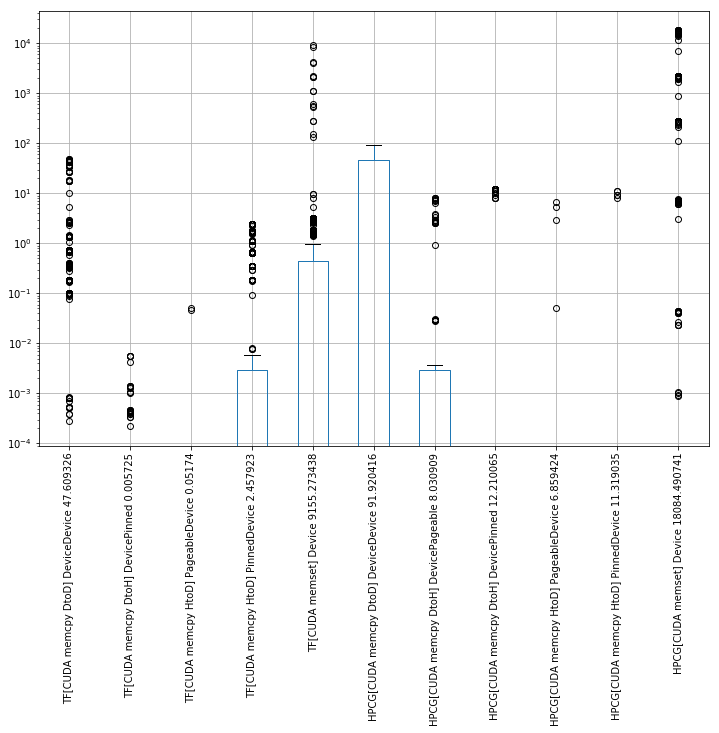

In [66]:
df_full.plot.box(logy = True, grid = True, rot=90)

### Split df_throughput into 2 dataframes for plotting based on max values

In [98]:
colD2D = [df_full.columns[0],df_full.columns[5]]
colmemset = [df_full.columns[4],df_full.columns[10]]
colHD1 = df_full.columns[1:4]
colHD2 = df_full.columns[6:10]
df_1 = df_full[colD2D].fillna(0)
df_2 = df_full[colmemset].fillna(0)
df_3 = df_full[colHD1 | colHD2].fillna(0)

In [99]:
df_1.iloc[:3]

,TF[CUDA memcpy DtoD] DeviceDevice 47.609326,HPCG[CUDA memcpy DtoD] DeviceDevice 91.920416
Start,,
0.817201,0.0,0.0
1.201508,0.0,0.0
1.201676,0.0,0.0


In [100]:
df_2.iloc[:3]

,TF[CUDA memset] Device 9155.273438,HPCG[CUDA memset] Device 18084.490741
Start,,
0.817201,0.231928,0.0
1.201508,0.000000,0.0
1.201676,0.000000,0.0


In [101]:
df_3.iloc[:3]

,HPCG[CUDA memcpy DtoH] DevicePageable 8.030909,HPCG[CUDA memcpy DtoH] DevicePinned 12.210065,HPCG[CUDA memcpy HtoD] PageableDevice 6.859424,HPCG[CUDA memcpy HtoD] PinnedDevice 11.319035,TF[CUDA memcpy DtoH] DevicePinned 0.005725,TF[CUDA memcpy HtoD] PageableDevice 0.05174,TF[CUDA memcpy HtoD] PinnedDevice 2.457923
Start,,,,,,,
0.817201,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1.201508,0.0,0.0,0.0,0.0,0.0,0.0,0.946105
1.201676,0.0,0.0,0.0,0.0,0.0,0.0,0.002985


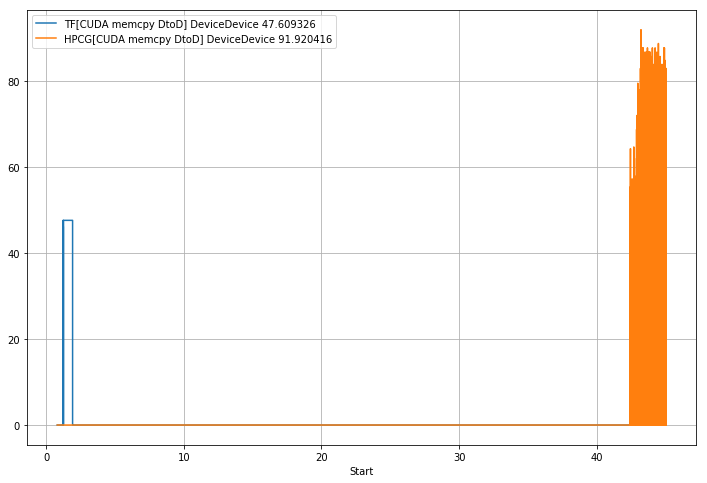

In [102]:
df_1.plot(drawstyle="steps-post", grid = True)

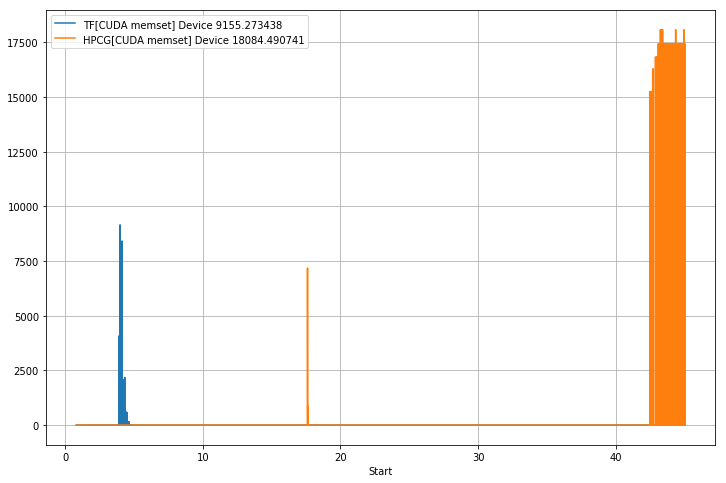

In [103]:
df_2.plot(drawstyle="steps-post", grid = True)

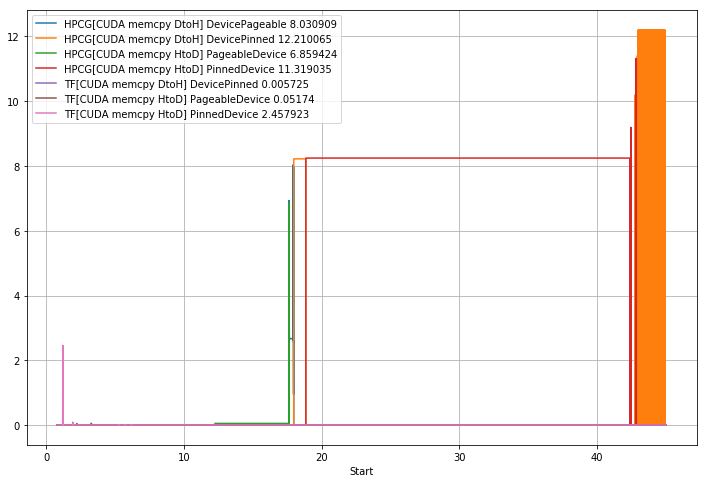

In [104]:
df_3.plot(drawstyle="steps-post", grid = True)